In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, sem
from datetime import datetime, timedelta

In [2]:
#Cмонтируем весь Google Disk в Colab:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Выгружаем данные о покупках в датафрейм
df_data = pd.read_excel(pd.ExcelFile('/content/gdrive/MyDrive/Colab Notebooks/DP/Dip.xlsx'), 'Данные')
df_data.head()

,id_order,id_client,amt_payment,dtime_pay
0,162295,203943.0,2802.0,2022-10-17 20:38:22.304000
1,185621,206742.0,4404.0,2022-12-13 09:47:43.880000
2,267875,183601.0,5192.0,2022-09-07 11:14:52.440000
3,173557,203446.0,2438.0,2022-09-07 08:23:40.021000
4,239130,188188.0,2488.0,2022-09-06 00:16:37.306000


In [4]:
#Выведем информацию о датасете - 4 столбца, 38691 строк. 
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38691 entries, 0 to 38690
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     38691 non-null  int64  
 1   id_client    38103 non-null  float64
 2   amt_payment  36536 non-null  float64
 3   dtime_pay    36519 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ MB


In [5]:
#Пустые значения содержатся в столбцах: 'id_client' - 588 значений, 'amt_payment' - 2 155, 'dtime_pay' - 2 172 значений.
df_data.isnull().sum()

id_order          0
id_client       588
amt_payment    2155
dtime_pay      2172
dtype: int64

In [6]:
#Удаляем строки содержащие пустые значения в столбцах 'id_client' и 'dtime_pay'
df_data.dropna(subset = ['id_client','dtime_pay'], inplace=True)
df_data.isnull().sum()

id_order       0
id_client      0
amt_payment    0
dtime_pay      0
dtype: int64

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36519 entries, 0 to 38690
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     36519 non-null  int64  
 1   id_client    36519 non-null  float64
 2   amt_payment  36519 non-null  float64
 3   dtime_pay    36519 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
#Преобразуем значения в столбце 'dtime_pay' в формат даты
df_data['dtime_pay'] = df_data['dtime_pay'].astype(str)
df_data['dtime_pay'] = pd.to_datetime(df_data['dtime_pay'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36519 entries, 0 to 38690
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     36519 non-null  int64         
 1   id_client    36519 non-null  float64       
 2   amt_payment  36519 non-null  float64       
 3   dtime_pay    36519 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.4 MB


In [9]:
#Выведем значения года, содержащегося 
df_data['dtime_pay'].dt.year.unique()

array([2022, 1900, 2023])

In [10]:
#Выведем строки, содержащие 1900 год - 262 строки
df_data.loc[df_data['dtime_pay'].dt.year == 1900]

,id_order,id_client,amt_payment,dtime_pay
133,131494,206705.0,2155.0,1900-01-21 12:02:37.152
217,146480,202160.0,4188.0,1900-01-19 03:52:40.299
315,213711,201967.0,3107.0,1900-04-18 23:01:04.162
414,164320,185535.0,2873.0,1900-01-19 01:48:40.617
466,248710,193942.0,4144.0,1900-05-08 07:29:28.342
...,...,...,...,...
38083,110084,185441.0,2316.0,1900-02-22 14:11:05.363
38282,277282,202071.0,2996.0,1900-04-02 04:35:55.847
38313,268826,196665.0,6511.0,1900-02-07 04:54:08.746
38524,115292,208053.0,3164.0,1900-04-21 16:06:17.630


In [11]:
#Выведем строки, содержащие 2023 год - 6 строк
df_data.loc[df_data['dtime_pay'].dt.year == 2023]

,id_order,id_client,amt_payment,dtime_pay
287,215699,209045.0,4087.0,2023-05-30 12:22:12.826
18174,214776,178690.0,3249.0,2023-05-30 01:48:21.187
23004,248132,178805.0,5846.0,2023-05-30 08:58:54.532
23087,205874,198821.0,3888.0,2023-05-30 16:35:44.003
31187,275182,200341.0,3253.0,2023-05-30 13:54:33.795
36173,246718,183668.0,5156.0,2023-05-30 18:10:59.392


In [12]:
#Оставим в очищенном датафремйме данные содержащие 2022 год - 36251 строка
df_data_clean = df_data.loc[df_data['dtime_pay'].dt.year == 2022]
df_data_clean = df_data_clean.reset_index()
df_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36251 entries, 0 to 36250
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        36251 non-null  int64         
 1   id_order     36251 non-null  int64         
 2   id_client    36251 non-null  float64       
 3   amt_payment  36251 non-null  float64       
 4   dtime_pay    36251 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.4 MB


In [ ]:
#Сохраним очищенные данные в файл
df_data_clean.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_data_clean.xlsx')
df_data_clean.head()

,index,id_order,id_client,amt_payment,dtime_pay
0,0,162295,203943.0,2802.0,2022-10-17 20:38:22.304
1,1,185621,206742.0,4404.0,2022-12-13 09:47:43.880
2,2,267875,183601.0,5192.0,2022-09-07 11:14:52.440
3,3,173557,203446.0,2438.0,2022-09-07 08:23:40.021
4,4,239130,188188.0,2488.0,2022-09-06 00:16:37.306


In [13]:
#Выгружаем данные о клиентах в датафрейм
df_clients = pd.read_excel(pd.ExcelFile('/content/gdrive/MyDrive/Colab Notebooks/DP/Dip.xlsx'), 'Clients')
df_clients.head()

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [14]:
#Выведем информацию о датасете - 4 столбца, 55605 строк.
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [15]:
#Пустые значения содержатся в столбце 'dtime_ad' - 249 значений
df_clients.isnull().sum()

id_client             0
dtime_ad            249
nflag_test            0
id_trading_point      0
dtype: int64

In [16]:
#Удаляем строки содержащие пустые значения в столбце 'dtime_ad'
df_clients.dropna(subset = 'dtime_ad', inplace=True)
df_clients.isnull().sum()

id_client           0
dtime_ad            0
nflag_test          0
id_trading_point    0
dtype: int64

In [17]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55356 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55356 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55356 non-null  int64         
 3   id_trading_point  55356 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.1 MB


In [18]:
#Выведем самую позднюю дату регистрации клиента - 29.08.2022
df_clients['dtime_ad'].max()

Timestamp('2022-08-29 00:02:17.878000')

In [19]:
#Выведем самую раннюю дату покупки клиента - 03.06.2022
#Выведем самую позднюю дату покупки клиента - 28.12.2022
print ('Самая поздняя дата покупки клиента - ', df_data_clean['dtime_pay'].max())
print ('Самая ранняя дата покупки клиента - ', df_data_clean['dtime_pay'].min())

Самая поздняя дата покупки клиента -  2022-12-28 22:57:20.608000
Самая ранняя дата покупки клиента -  2022-06-03 17:48:54.432000


In [21]:
#В сентябре, октябре, ноябре, декабре новых клиентов не регистрировалось. Данные по декабрю не полные.
#Таким образом, для проведения АБ теста используем данные за 3 месяца: сентябрь, октябрь, ноябрь 2022 года.
df_data_9_11 = df_data_clean.loc[(df_data_clean['dtime_pay'].dt.month < 12) & (df_data_clean['dtime_pay'].dt.month > 8)]
#Сохраним очищенные данные в файл
df_data_9_11.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_data_9_11.xlsx')
df_data_9_11.head()

,index,id_order,id_client,amt_payment,dtime_pay
0,0,162295,203943.0,2802.0,2022-10-17 20:38:22.304
2,2,267875,183601.0,5192.0,2022-09-07 11:14:52.440
3,3,173557,203446.0,2438.0,2022-09-07 08:23:40.021
4,4,239130,188188.0,2488.0,2022-09-06 00:16:37.306
5,5,202161,196151.0,2900.0,2022-10-22 23:21:01.660


In [22]:
df_data_9_11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20745 entries, 0 to 36250
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        20745 non-null  int64         
 1   id_order     20745 non-null  int64         
 2   id_client    20745 non-null  float64       
 3   amt_payment  20745 non-null  float64       
 4   dtime_pay    20745 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 972.4 KB


In [ ]:
#Сохраним очищенные данные в файл
df_clients.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_clients.xlsx')
df_clients.head()

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015
5,254313,2022-06-19 22:18:01.770,1,453


In [23]:
#Выгружаем данные о торговых точках в датафрейм
df_tp = pd.read_excel(pd.ExcelFile('/content/gdrive/MyDrive/Colab Notebooks/DP/Dip.xlsx'), 'Region_dict')
df_tp.head()

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


In [24]:
#Выведем информацию о датасете - 2 столбца, 66 строк - пустые значения отстутсвуют
df_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_trading_point  66 non-null     int64 
 1   city              66 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


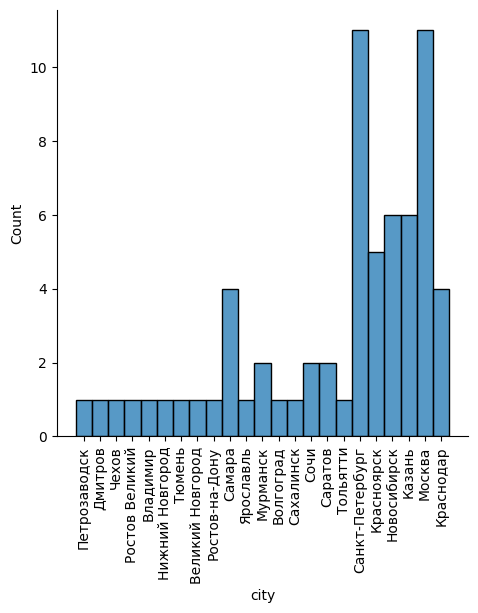

In [25]:
#Построим гистограмму распределения торговых точек
sns.displot(df_tp, x = 'city')
plt.xticks(rotation=90)
plt.show()

In [26]:
#Пустых значений в датафрейме не содержится
df_tp.isnull().sum()

id_trading_point    0
city                0
dtype: int64

In [27]:
#Исследуем количество торговых точек в каждом городе
df_tp_hist = df_tp.groupby('city').count().reset_index()
df_tp_hist.columns = ['city','quan_tp']
df_tp_hist

,city,quan_tp
0,Великий Новгород,1
1,Владимир,1
2,Волгоград,1
3,Дмитров,1
4,Казань,6
5,Краснодар,4
6,Красноярск,5
7,Москва,11
8,Мурманск,2
9,Нижний Новгород,1


<function matplotlib.pyplot.show(close=None, block=None)>

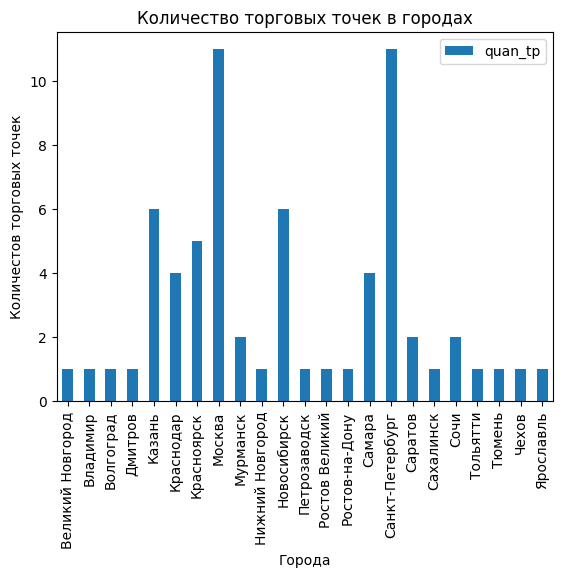

In [28]:
#Построим гистограмму распределения количества торговых точек по городам
df_tp_hist.plot.bar(y ='quan_tp', x = 'city')
plt.title('Количество торговых точек в городах')
plt.xlabel('Города')
plt.ylabel('Количестов торговых точек')
plt.show

In [29]:
df_data_9_11['id_client'] = df_data_9_11['id_client'].astype(int)
df_data_9_11

<ipython-input-29-177d04fea239>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_9_11['id_client'] = df_data_9_11['id_client'].astype(int)


,index,id_order,id_client,amt_payment,dtime_pay
0,0,162295,203943,2802.0,2022-10-17 20:38:22.304
2,2,267875,183601,5192.0,2022-09-07 11:14:52.440
3,3,173557,203446,2438.0,2022-09-07 08:23:40.021
4,4,239130,188188,2488.0,2022-09-06 00:16:37.306
5,5,202161,196151,2900.0,2022-10-22 23:21:01.660
...,...,...,...,...,...
36244,38684,110483,196771,2133.0,2022-10-26 10:10:44.299
36245,38685,171359,186697,3628.0,2022-10-30 08:50:42.320
36247,38687,174414,187403,3284.0,2022-10-01 14:35:56.818
36249,38689,218517,208436,1983.0,2022-11-12 17:05:48.765


In [30]:
#Соединим (по клиенту)  таблицу с платежами с клиентской таблицей
df_clients_merge = pd.merge(df_data_9_11, df_clients, how='left', left_on='id_client', right_on='id_client')
df_clients_merge = df_clients_merge.fillna(0)
df_clients_merge[['index','id_order']] = df_clients_merge[['index','id_order']].astype(int)
df_clients_merge = df_clients_merge.drop(columns=['index','dtime_ad'])
df_clients_merge

,id_order,id_client,amt_payment,dtime_pay,nflag_test,id_trading_point
0,162295,203943,2802.0,2022-10-17 20:38:22.304,0,1654
1,267875,183601,5192.0,2022-09-07 11:14:52.440,0,88
2,173557,203446,2438.0,2022-09-07 08:23:40.021,0,891
3,239130,188188,2488.0,2022-09-06 00:16:37.306,0,46
4,202161,196151,2900.0,2022-10-22 23:21:01.660,0,1015
...,...,...,...,...,...,...
20740,110483,196771,2133.0,2022-10-26 10:10:44.299,1,2652
20741,171359,186697,3628.0,2022-10-30 08:50:42.320,1,516
20742,174414,187403,3284.0,2022-10-01 14:35:56.818,1,439
20743,218517,208436,1983.0,2022-11-12 17:05:48.765,0,800


In [31]:
#С помощью словаря регионов подтянем к каждой торговой точке город, в котором она находится.
df_clients_merge_city = pd.merge(df_clients_merge, df_tp, how='left', left_on='id_trading_point', right_on='id_trading_point')
df_clients_merge_city.head()

,id_order,id_client,amt_payment,dtime_pay,nflag_test,id_trading_point,city
0,162295,203943,2802.0,2022-10-17 20:38:22.304,0,1654,Москва
1,267875,183601,5192.0,2022-09-07 11:14:52.440,0,88,Тольятти
2,173557,203446,2438.0,2022-09-07 08:23:40.021,0,891,Санкт-Петербург
3,239130,188188,2488.0,2022-09-06 00:16:37.306,0,46,Ярославль
4,202161,196151,2900.0,2022-10-22 23:21:01.660,0,1015,Краснодар


In [32]:
df_clients_merge_city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20745 entries, 0 to 20744
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_order          20745 non-null  int64         
 1   id_client         20745 non-null  int64         
 2   amt_payment       20745 non-null  float64       
 3   dtime_pay         20745 non-null  datetime64[ns]
 4   nflag_test        20745 non-null  int64         
 5   id_trading_point  20745 non-null  int64         
 6   city              20745 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 1.3+ MB


In [33]:
#Создадим поле флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет.
df_clients_merge_city['pay_flag'] = np.where(df_clients_merge_city['amt_payment']>0, 1, 0)
df_clients_merge_city.head()

,id_order,id_client,amt_payment,dtime_pay,nflag_test,id_trading_point,city,pay_flag
0,162295,203943,2802.0,2022-10-17 20:38:22.304,0,1654,Москва,1
1,267875,183601,5192.0,2022-09-07 11:14:52.440,0,88,Тольятти,1
2,173557,203446,2438.0,2022-09-07 08:23:40.021,0,891,Санкт-Петербург,1
3,239130,188188,2488.0,2022-09-06 00:16:37.306,0,46,Ярославль,1
4,202161,196151,2900.0,2022-10-22 23:21:01.660,0,1015,Краснодар,1


In [34]:
#Выведем список всех торговые точки, в которых не было заплачено ни одного рубля ни одним клиентом
df_tp_sum = df_clients_merge_city.groupby(['id_trading_point','nflag_test']).sum().reset_index()
df_tp_sum

<ipython-input-34-7498daeb339e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tp_sum = df_clients_merge_city.groupby(['id_trading_point','nflag_test']).sum().reset_index()


,id_trading_point,nflag_test,id_order,id_client,amt_payment,pay_flag
0,2,0,1102765,989766,19483.0,5
1,2,1,2222835,2118678,35447.0,11
2,11,0,40826084,40189891,732763.0,204
3,11,1,39358551,39029778,738134.0,199
4,19,0,7543983,8437603,147351.0,43
...,...,...,...,...,...,...
106,8543,1,9285466,8746251,160185.0,45
107,9121,0,7064805,6515896,107268.0,33
108,9121,1,8962779,8654667,164307.0,44
109,9931,0,9083073,8862996,154227.0,46


In [35]:
df_tp_no_pay = df_tp_sum.loc[df_tp_sum['amt_payment'] == 0]['id_trading_point'].unique()
df_tp_no_pay

array([], dtype=int64)

In [36]:
#Добавим к списку все торговые точки, в которых пустует или контрольная, или тестовая группа.
i = 0
while i < df_tp_sum.shape[0]:
    if df_tp_sum.iloc[i]['id_trading_point'] == df_tp_sum.iloc[i+1]['id_trading_point']:
        i = i + 2
    else:
        df_tp_no_pay = np.append(df_tp_no_pay, df_tp_sum.iloc[i]['id_trading_point'])    
        i = i + 1
df_tp_no_pay.astype(int)

array([  46,  228,  603,  739,  800,  810,  866, 1015, 1099])

In [37]:
#удалим торговые точки
df_not_pay = df_clients_merge_city[df_clients_merge_city.id_trading_point.isin(df_tp_no_pay) == False].reset_index()
df_not_pay

,index,id_order,id_client,amt_payment,dtime_pay,nflag_test,id_trading_point,city,pay_flag
0,0,162295,203943,2802.0,2022-10-17 20:38:22.304,0,1654,Москва,1
1,1,267875,183601,5192.0,2022-09-07 11:14:52.440,0,88,Тольятти,1
2,2,173557,203446,2438.0,2022-09-07 08:23:40.021,0,891,Санкт-Петербург,1
3,5,219886,194212,2180.0,2022-11-14 19:50:35.959,0,112,Санкт-Петербург,1
4,6,123132,206076,558.0,2022-10-28 02:00:33.837,0,1101,Краснодар,1
...,...,...,...,...,...,...,...,...,...
17302,20739,197572,196516,3912.0,2022-10-15 00:22:08.070,0,54,Мурманск,1
17303,20740,110483,196771,2133.0,2022-10-26 10:10:44.299,1,2652,Москва,1
17304,20741,171359,186697,3628.0,2022-10-30 08:50:42.320,1,516,Казань,1
17305,20742,174414,187403,3284.0,2022-10-01 14:35:56.818,1,439,Казань,1


In [38]:
#Построим агрегацию таблицы с платежами, где вычислим среднюю сумму платежей на каждого клиента
df_data_mean_pay = df_not_pay.groupby('id_client').mean('amt_payment').reset_index()
df_data_mean_pay = df_data_mean_pay[['id_client', 'amt_payment']]
df_data_mean_pay

,id_client,amt_payment
0,178563,768.0
1,178570,4644.0
2,178572,1828.0
3,178575,4313.5
4,178577,6027.0
...,...,...
14971,209624,6261.0
14972,209626,1198.0
14973,209628,1989.0
14974,209630,6927.0


In [39]:
df_not_pay = pd.merge(df_data_mean_pay, df_clients, how='left', left_on='id_client', right_on='id_client')
df_not_pay = df_not_pay.drop(columns = 'dtime_ad')
#С помощью словаря регионов подтянем к каждой торговой точке город, в котором она находится.
df_not_pay_city = pd.merge(df_not_pay, df_tp, how='left', left_on='id_trading_point', right_on='id_trading_point')
#Создадим поле флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет.
df_not_pay_city['pay_flag'] = np.where(df_not_pay_city['amt_payment']>0, 1, 0)
df_not_pay_city

,id_client,amt_payment,nflag_test,id_trading_point,city,pay_flag
0,178563,768.0,1,112,Санкт-Петербург,1
1,178570,4644.0,1,80,Саратов,1
2,178572,1828.0,0,88,Тольятти,1
3,178575,4313.5,1,55,Мурманск,1
4,178577,6027.0,1,477,Казань,1
...,...,...,...,...,...,...
14971,209624,6261.0,0,82,Саратов,1
14972,209626,1198.0,0,3987,Москва,1
14973,209628,1989.0,1,3987,Москва,1
14974,209630,6927.0,1,112,Санкт-Петербург,1


In [40]:
#Сохраним очищенные данные по платежам за 3 месяца в файл
df_not_pay_city.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_not_pay_9_11.xlsx')

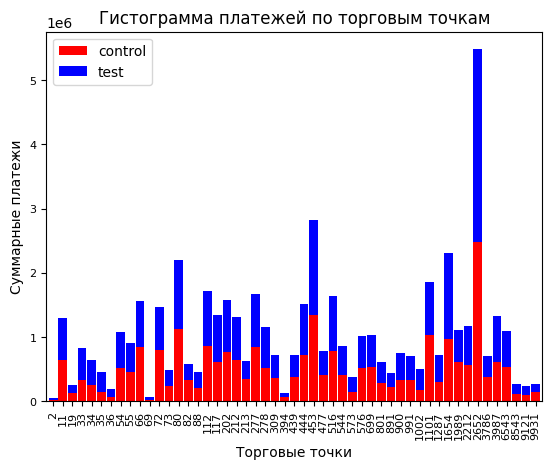

In [41]:
#Гистограмма платежей по торговым точкам, на которой различными цветами изображены группы “тест” и “контроль”
df_hist = df_not_pay_city[['nflag_test', 'id_trading_point', 'amt_payment']].groupby(['nflag_test', 'id_trading_point']).sum().reset_index()
tp_0 = df_hist.loc[df_hist['nflag_test'] == 0].drop(columns = 'nflag_test')
tp_1 = df_hist.loc[df_hist['nflag_test'] == 1].drop(columns = 'nflag_test')
ig, ax = plt.subplots()
tp_0.plot.bar(y = 'amt_payment', x = 'id_trading_point', color = 'r', label = 'control', ax = ax, width=0.9)
tp_1.plot.bar(y = 'amt_payment', x = 'id_trading_point', bottom = tp_0['amt_payment'], color = 'b', label = 'test', ax = ax, width=0.9)
plt.title('Гистограмма платежей по торговым точкам')
plt.xlabel('Торговые точки')
plt.ylabel ('Суммарные платежи')
ax.tick_params(labelsize=8)
plt.show()

In [42]:
#Разобъем датафрейм на контрольную выборку и
df_0 = df_not_pay_city.loc[df_not_pay['nflag_test'] == 0]
df_0.head()

,id_client,amt_payment,nflag_test,id_trading_point,city,pay_flag
2,178572,1828.0,0,88,Тольятти,1
5,178579,817.0,0,112,Санкт-Петербург,1
10,178594,2995.0,0,1654,Москва,1
11,178598,4224.0,0,117,Санкт-Петербург,1
12,178608,4974.0,0,212,Красноярск,1


In [43]:
#Разобъем датафрейм на тестовую выборку
df_1 = df_not_pay_city.loc[df_not_pay['nflag_test'] == 1]
df_1.head()

,id_client,amt_payment,nflag_test,id_trading_point,city,pay_flag
0,178563,768.0,1,112,Санкт-Петербург,1
1,178570,4644.0,1,80,Саратов,1
3,178575,4313.5,1,55,Мурманск,1
4,178577,6027.0,1,477,Казань,1
6,178584,3335.0,1,439,Казань,1


In [46]:
#Гипотеза H0: значения статистически значимо не отличаются
def ttest_calc (r1, r2, alpha):
    s,p = ttest_ind(r1, r2)
    if p < alpha:
        hyp = 1
        print ('Гипотеза H0 не подтверждается: значения статистически значимо отличаются')
    else:
        hyp = 0
        print ('Гипотеза H0 подтверждается: значения статистически значимо не отличаются')
    r1_mean = r1.mean()
    r2_mean = r2.mean()
    diff_mean = r1.mean()-r2.mean()
    print("Среднее значение 1 ряда", r1_mean)
    print("Среднее значение 2 ряда", r2_mean)
    print("Разница средних = ", diff_mean)
    print("P_value = ",p)
    return s, p


In [47]:
#Сравним средние платежи для всей выборки
ttest_calc (df_0['amt_payment'], df_1['amt_payment'], 0.05)

Гипотеза H0 не подтверждается: значения статистически значимо отличаются
Среднее значение 1 ряда 3508.482502670105
Среднее значение 2 ряда 3583.364284316284
Разница средних =  -74.88178164617875
P_value =  0.0009204088129552426


(-3.3144521522760453, 0.0009204088129552426)

In [48]:
#Сравним средние платежи для выборки по городам
for i in df_not_pay_city['city'].unique():
    print (i)
    ttest_calc (df_0.loc[df_0['city'] == i]['amt_payment'], df_1.loc[df_1['city'] == i]['amt_payment'], 0.05)

Санкт-Петербург
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 3464.1205397470635
Среднее значение 2 ряда 3472.8320586360737
Разница средних =  -8.711518889010222
P_value =  0.8630712357439483
Саратов
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 3536.3214285714284
Среднее значение 2 ряда 3506.673351158646
Разница средних =  29.64807741278264
P_value =  0.7661429403293488
Тольятти
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 3273.405128205128
Среднее значение 2 ряда 3403.553240740741
Разница средних =  -130.14811253561265
P_value =  0.6032157661356785
Мурманск
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 3500.3667861409795
Среднее значение 2 ряда 3454.8603603603606
Разница средних =  45.50642578061888
P_value =  0.6917500906691079
Казань
Гипотеза H0 подтверждается: значения статистиче

In [49]:
#функция расчета данных АБ теста
def ttest_df (r1, r2, alpha):
    s,p = ttest_ind(r1, r2)
    if p < alpha:
        hyp = 1
    else:
        hyp = 0
    r1_mean = r1.mean()
    r2_mean = r2.mean()
    diff_mean = r1.mean()-r2.mean()
    return r1_mean, r2_mean, diff_mean, s, p, hyp

In [50]:
#Создаем датафрейм для результата теста по городам
df_city = []
df_city = pd.DataFrame(columns=['mean_control', 'mean_test', 'diff_mean', 'mean_ttest', 'mean_pvalue_ttest', 'hyp', 'city'])
df_city

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city


In [51]:
# Сведем результаты A/B-теста по средним платежам для каждого города в один датафрейм
# Рассчитаем результаты A/B-теста для каждого города в отдельности
for i in df_not_pay_city['city'].unique():
    df_city.loc[len(df_city.index)] = ttest_df (df_0.loc[df_0['city'] == i]['amt_payment'], df_1.loc[df_1['city'] == i]['amt_payment'], 0.05) + (i,)
df_city

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city
0,3464.120540,3472.832059,-8.711519,-0.172481,8.630712e-01,0,Санкт-Петербург
1,3536.321429,3506.673351,29.648077,0.297527,7.661429e-01,0,Саратов
2,3273.405128,3403.553241,-130.148113,-0.521007,6.032158e-01,0,Тольятти
3,3500.366786,3454.860360,45.506426,0.396681,6.917501e-01,0,Мурманск
4,3627.034932,3713.982186,-86.947254,-1.311722,1.898065e-01,0,Казань
5,3521.994165,3785.673293,-263.679128,-5.884136,4.342374e-09,1,Москва
6,3464.138366,3516.617092,-52.478725,-0.872204,3.831987e-01,0,Красноярск
7,3600.663763,3488.535354,112.128410,0.961348,3.368006e-01,0,Сочи
8,3450.536017,3432.845745,17.690272,0.153286,8.782233e-01,0,Самара
9,3896.600000,3124.375000,772.225000,1.003008,3.374108e-01,0,Дмитров


In [52]:
#Функция критерия Манна-Уитни
def mann_whitney_func(r1, r2, alpha=0.05):
    s, p = mannwhitneyu(r1, r2)
    if p < alpha:
        h = 'Распределения не равны'
    else:
        h = 'Распределения равны'
    return h, s, p

In [53]:
#Сравним распределение средних платежей для всей выборки
mann_whitney_func (df_0['amt_payment'], df_1['amt_payment'], 0.05)

('Распределения не равны', 27053925.0, 0.00026084418725439855)

In [54]:
#Создадим пустой датафрейм для критерия Манна-Уитни
df_mw = []
df_mw = pd.DataFrame(columns=['hyp_mw', 's_mw', 'p_value_mw', 'city'])
df_mw

,hyp_mw,s_mw,p_value_mw,city


In [55]:
#Сравним распределение средних платежей для выборки по городам
for i in df_not_pay_city['city'].unique():
    mw = mann_whitney_func (df_0.loc[df_0['city'] == i]['amt_payment'], df_1.loc[df_1['city'] == i]['amt_payment'], 0.05)
    print (i, mw)
    df_mw.loc[len(df_mw.index)] = mw + (i,)
df_mw   

Санкт-Петербург ('Распределения равны', 1156169.5, 0.9423940421997047)
Саратов ('Распределения равны', 78493.0, 0.692031750670226)
Тольятти ('Распределения равны', 2239.0, 0.6648630970407129)
Мурманск ('Распределения равны', 41440.5, 0.9407438300374333)
Казань ('Распределения равны', 290832.0, 0.08684947556041865)
Москва ('Распределения не равны', 1631602.0, 2.9867241348464505e-10)
Красноярск ('Распределения равны', 523531.5, 0.4070002724390759)
Сочи ('Распределения равны', 39454.0, 0.4005174877087324)
Самара ('Распределения равны', 44875.5, 0.8117783477003016)
Дмитров ('Распределения равны', 26.0, 0.43512043512043513)
Владимир ('Распределения равны', 14658.0, 0.26011908898935154)
Волгоград ('Распределения равны', 28406.5, 0.2029506367724938)
Краснодар ('Распределения равны', 92393.0, 0.6795136030859596)
Тюмень ('Распределения равны', 762.5, 0.9840484863850323)
Сахалинск ('Распределения равны', 29.0, 0.5414232825997531)


,hyp_mw,s_mw,p_value_mw,city
0,Распределения равны,1156169.5,9.423940e-01,Санкт-Петербург
1,Распределения равны,78493.0,6.920318e-01,Саратов
2,Распределения равны,2239.0,6.648631e-01,Тольятти
3,Распределения равны,41440.5,9.407438e-01,Мурманск
4,Распределения равны,290832.0,8.684948e-02,Казань
5,Распределения не равны,1631602.0,2.986724e-10,Москва
6,Распределения равны,523531.5,4.070003e-01,Красноярск
7,Распределения равны,39454.0,4.005175e-01,Сочи
8,Распределения равны,44875.5,8.117783e-01,Самара
9,Распределения равны,26.0,4.351204e-01,Дмитров


In [56]:
#Склеим 2 датафрейма
df_ttest_city = pd.merge(df_city, df_mw)
df_ttest_city

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city,hyp_mw,s_mw,p_value_mw
0,3464.120540,3472.832059,-8.711519,-0.172481,8.630712e-01,0,Санкт-Петербург,Распределения равны,1156169.5,9.423940e-01
1,3536.321429,3506.673351,29.648077,0.297527,7.661429e-01,0,Саратов,Распределения равны,78493.0,6.920318e-01
2,3273.405128,3403.553241,-130.148113,-0.521007,6.032158e-01,0,Тольятти,Распределения равны,2239.0,6.648631e-01
3,3500.366786,3454.860360,45.506426,0.396681,6.917501e-01,0,Мурманск,Распределения равны,41440.5,9.407438e-01
4,3627.034932,3713.982186,-86.947254,-1.311722,1.898065e-01,0,Казань,Распределения равны,290832.0,8.684948e-02
5,3521.994165,3785.673293,-263.679128,-5.884136,4.342374e-09,1,Москва,Распределения не равны,1631602.0,2.986724e-10
6,3464.138366,3516.617092,-52.478725,-0.872204,3.831987e-01,0,Красноярск,Распределения равны,523531.5,4.070003e-01
7,3600.663763,3488.535354,112.128410,0.961348,3.368006e-01,0,Сочи,Распределения равны,39454.0,4.005175e-01
8,3450.536017,3432.845745,17.690272,0.153286,8.782233e-01,0,Самара,Распределения равны,44875.5,8.117783e-01
9,3896.600000,3124.375000,772.225000,1.003008,3.374108e-01,0,Дмитров,Распределения равны,26.0,4.351204e-01


In [ ]:
#Сохраним данные в файл
df_ttest_city.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_ttest_city_9_11.xlsx')

In [57]:
#удалим торговые точки (1, 4, 7, 13, 23, 26, 46, 228, 603, 739, 800, 810, 866, 1015, 1099)
df_no_tp = [1, 4, 7, 13, 23, 26, 46, 228, 603, 739, 800, 810, 866, 1015, 1099]


In [58]:
#Датафреймы для расчета конверсии
df_conv = pd.merge(df_clients, df_not_pay_city, how = 'left', on = 'id_client')
df_conv = df_conv.fillna(0)
df_conv = df_conv.drop(columns=['nflag_test_y','id_trading_point_y', 'city'])
df_conv 

,id_client,dtime_ad,nflag_test_x,id_trading_point_x,amt_payment,pay_flag
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0
1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0
2,183981,2022-06-16 12:23:59.289,1,991,2592.0,1.0
3,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0
4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0
...,...,...,...,...,...,...
55351,193038,2022-07-09 00:31:25.196,0,1015,0.0,0.0
55352,244069,2022-08-08 00:12:31.319,1,991,0.0,0.0
55353,189084,2022-06-29 04:34:42.610,1,439,0.0,0.0
55354,182758,2022-06-13 11:28:37.856,1,573,0.0,0.0


In [59]:
df_conv.columns = ['id_client', 'dtime_ad', 'nflag_test', 'id_trading_point', 'amt_payment', 'pay_flag']
df_conv.head()

,id_client,dtime_ad,nflag_test,id_trading_point,amt_payment,pay_flag
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0
1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0
2,183981,2022-06-16 12:23:59.289,1,991,2592.0,1.0
3,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0
4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0


In [60]:
df_conv_not_tp = df_conv[df_conv.id_trading_point.isin(df_no_tp) == False].reset_index()
df_conv_not_tp = pd.merge(df_conv_not_tp, df_tp, how = 'left', on = 'id_trading_point')
df_conv_not_tp

,index,id_client,dtime_ad,nflag_test,id_trading_point,amt_payment,pay_flag,city
0,0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0,Красноярск
1,1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0,Мурманск
2,2,183981,2022-06-16 12:23:59.289,1,991,2592.0,1.0,Казань
3,4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0,Санкт-Петербург
4,5,195818,2022-07-16 01:30:59.088,1,2652,0.0,0.0,Москва
...,...,...,...,...,...,...,...,...
45313,55350,188702,2022-06-28 06:16:25.664,0,453,1323.0,1.0,Санкт-Петербург
45314,55352,244069,2022-08-08 00:12:31.319,1,991,0.0,0.0,Казань
45315,55353,189084,2022-06-29 04:34:42.610,1,439,0.0,0.0,Казань
45316,55354,182758,2022-06-13 11:28:37.856,1,573,0.0,0.0,Санкт-Петербург


In [61]:
df_conv_0 = df_conv_not_tp.loc[df_conv_not_tp['nflag_test'] == 0]
df_conv_0.head()

,index,id_client,dtime_ad,nflag_test,id_trading_point,amt_payment,pay_flag,city
0,0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0,Красноярск
6,9,200225,2022-07-27 00:18:47.370,0,453,1396.0,1.0,Санкт-Петербург
7,12,212625,2022-08-16 14:19:05.040,0,278,0.0,0.0,Красноярск
10,15,205357,2022-08-08 21:22:23.684,0,453,2818.0,1.0,Санкт-Петербург
11,16,205352,2022-08-08 20:59:32.806,0,2652,0.0,0.0,Москва


In [62]:
df_conv_1 = df_conv_not_tp.loc[df_conv_not_tp['nflag_test'] == 1]
df_conv_1.head()

,index,id_client,dtime_ad,nflag_test,id_trading_point,amt_payment,pay_flag,city
1,1,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0,Мурманск
2,2,183981,2022-06-16 12:23:59.289,1,991,2592.0,1.0,Казань
3,4,254313,2022-06-19 22:18:01.770,1,453,0.0,0.0,Санкт-Петербург
4,5,195818,2022-07-16 01:30:59.088,1,2652,0.0,0.0,Москва
5,8,274394,2022-06-25 00:46:07.492,1,2652,0.0,0.0,Москва


In [63]:
#Сравним конверсию в платеж для всей выборки
print (ttest_calc (df_conv_0['pay_flag'], df_conv_1['pay_flag'], 0.05))

Гипотеза H0 не подтверждается: значения статистически значимо отличаются
Среднее значение 1 ряда 0.31967822323263234
Среднее значение 2 ряда 0.341456894631321
Разница средних =  -0.021778671398688665
P_value =  8.286546705712941e-07
(-4.929182681488281, 8.286546705712941e-07)


In [64]:
#Сравним конверсию в платеж для выборки по городам
for i in df_not_pay_city['city'].unique():
    print ('Конверсия в платеж для города', i)
    print (ttest_calc (df_conv_0.loc[df_conv_0['city'] == i]['pay_flag'], df_conv_1.loc[df_conv_1['city'] == i]['pay_flag'], 0.05))

Конверсия в платеж для города Санкт-Петербург
Гипотеза H0 не подтверждается: значения статистически значимо отличаются
Среднее значение 1 ряда 0.33288227334235454
Среднее значение 2 ряда 0.3529808773903262
Разница средних =  -0.020098604047971647
P_value =  0.04606823093134375
(-1.995047369709111, 0.04606823093134375)
Конверсия в платеж для города Саратов
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 0.37240757439134353
Среднее значение 2 ряда 0.36920039486673245
Разница средних =  0.0032071795246110812
P_value =  0.8786502102192035
(0.15269896243285364, 0.8786502102192035)
Конверсия в платеж для города Тольятти
Гипотеза H0 подтверждается: значения статистически значимо не отличаются
Среднее значение 1 ряда 0.38922155688622756
Среднее значение 2 ряда 0.37894736842105264
Разница средних =  0.010274188465174916
P_value =  0.8426643134233887
(0.19863201530689617, 0.8426643134233887)
Конверсия в платеж для города Мурманск
Гипотеза H0 подтв

In [65]:
#Создадим пустой датафрейм для конверсии в платеж
df_conv_city = []
df_conv_city = pd.DataFrame(columns=['mean_control', 'mean_test', 'diff_mean', 'mean_ttest', 'mean_pvalue_ttest', 'hyp', 'city'])
df_conv_city

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city


In [66]:
# Сведем результаты A/B-теста по конверсии для каждого города в один датафрейм
# Рассчитаем результаты A/B-теста для каждого города в отдельности
for i in df_not_pay_city['city'].unique():
    df_conv_city.loc[len(df_conv_city.index)] = ttest_df (df_conv_0.loc[df_conv_0['city'] == i]['pay_flag'], df_conv_1.loc[df_conv_1['city'] == i]['pay_flag'], 0.05) + (i,)
df_conv_city

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city
0,0.332882,0.352981,-0.020099,-1.995047,4.606823e-02,1,Санкт-Петербург
1,0.372408,0.369200,0.003207,0.152699,8.786502e-01,0,Саратов
2,0.389222,0.378947,0.010274,0.198632,8.426643e-01,0,Тольятти
3,0.261972,0.280569,-0.018597,-0.962723,3.357967e-01,0,Мурманск
4,0.305782,0.310800,-0.005018,-0.387039,6.987433e-01,0,Казань
5,0.290488,0.333388,-0.042899,-5.152579,2.608889e-07,1,Москва
6,0.348276,0.348699,-0.000424,-0.034227,9.726969e-01,0,Красноярск
7,0.356079,0.331658,0.024421,1.028527,3.038573e-01,0,Сочи
8,0.278960,0.468828,-0.189868,-8.126933,8.560318e-16,1,Самара
9,0.070423,0.102564,-0.032142,-0.690820,4.907681e-01,0,Дмитров


In [67]:
#Сравним распределение конверсии для всей выборки
mann_whitney_func (df_conv_0['pay_flag'], df_conv_1['pay_flag'], 0.05)

('Распределения не равны', 251101826.5, 8.311145254050117e-07)

In [68]:
#Создадим пустой датафрейм для конверсии по критерию Манна-Уитни
df_conv_mw = []
df_conv_mw = pd.DataFrame(columns=['hyp_mw', 's_mw', 'p_value_mw', 'city'])
df_conv_mw

,hyp_mw,s_mw,p_value_mw,city


In [69]:
#Сравним распределение конверсии для выборки по городам
for i in df_not_pay_city['city'].unique():
    mw_conv = mann_whitney_func (df_conv_0.loc[df_conv_0['city'] == i]['pay_flag'], df_conv_1.loc[df_conv_1['city'] == i]['pay_flag'], 0.05)
    print (i, mw_conv)
    df_conv_mw.loc[len(df_conv_mw.index)] = mw_conv + (i,)
df_conv_mw   

Санкт-Петербург ('Распределения не равны', 9656502.0, 0.04607478389273332)
Саратов ('Распределения равны', 563510.0, 0.8786413738446277)
Тольятти ('Распределения равны', 16028.0, 0.8428178583018919)
Мурманск ('Распределения равны', 551340.0, 0.33570154737707525)
Казань ('Распределения равны', 3205085.5, 0.6987119783032618)
Москва ('Распределения не равны', 18270104.0, 2.6432220896348255e-07)
Красноярск ('Распределения равны', 4401785.0, 0.9727008101629426)
Сочи ('Распределения равны', 328622.0, 0.3037414116840026)
Самара ('Распределения не равны', 274834.0, 1.5740849328864654e-15)
Дмитров ('Распределения равны', 2680.0, 0.49135493061920554)
Владимир ('Распределения равны', 147904.5, 0.11470167899202109)
Волгоград ('Распределения равны', 235142.5, 0.4786335368538184)
Краснодар ('Распределения равны', 604493.0, 0.08262524086307602)
Тюмень ('Распределения равны', 9316.0, 0.7367958618373276)
Сахалинск ('Распределения равны', 2874.0, 0.7349202660982574)


,hyp_mw,s_mw,p_value_mw,city
0,Распределения не равны,9656502.0,4.607478e-02,Санкт-Петербург
1,Распределения равны,563510.0,8.786414e-01,Саратов
2,Распределения равны,16028.0,8.428179e-01,Тольятти
3,Распределения равны,551340.0,3.357015e-01,Мурманск
4,Распределения равны,3205085.5,6.987120e-01,Казань
5,Распределения не равны,18270104.0,2.643222e-07,Москва
6,Распределения равны,4401785.0,9.727008e-01,Красноярск
7,Распределения равны,328622.0,3.037414e-01,Сочи
8,Распределения не равны,274834.0,1.574085e-15,Самара
9,Распределения равны,2680.0,4.913549e-01,Дмитров


In [70]:
#Склеим 2 датафрейма
df_ttest_conv = pd.merge(df_conv_city, df_conv_mw)
df_ttest_conv

,mean_control,mean_test,diff_mean,mean_ttest,mean_pvalue_ttest,hyp,city,hyp_mw,s_mw,p_value_mw
0,0.332882,0.352981,-0.020099,-1.995047,4.606823e-02,1,Санкт-Петербург,Распределения не равны,9656502.0,4.607478e-02
1,0.372408,0.369200,0.003207,0.152699,8.786502e-01,0,Саратов,Распределения равны,563510.0,8.786414e-01
2,0.389222,0.378947,0.010274,0.198632,8.426643e-01,0,Тольятти,Распределения равны,16028.0,8.428179e-01
3,0.261972,0.280569,-0.018597,-0.962723,3.357967e-01,0,Мурманск,Распределения равны,551340.0,3.357015e-01
4,0.305782,0.310800,-0.005018,-0.387039,6.987433e-01,0,Казань,Распределения равны,3205085.5,6.987120e-01
5,0.290488,0.333388,-0.042899,-5.152579,2.608889e-07,1,Москва,Распределения не равны,18270104.0,2.643222e-07
6,0.348276,0.348699,-0.000424,-0.034227,9.726969e-01,0,Красноярск,Распределения равны,4401785.0,9.727008e-01
7,0.356079,0.331658,0.024421,1.028527,3.038573e-01,0,Сочи,Распределения равны,328622.0,3.037414e-01
8,0.278960,0.468828,-0.189868,-8.126933,8.560318e-16,1,Самара,Распределения не равны,274834.0,1.574085e-15
9,0.070423,0.102564,-0.032142,-0.690820,4.907681e-01,0,Дмитров,Распределения равны,2680.0,4.913549e-01


In [ ]:
#Сохраним данные в файл
df_ttest_conv.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/df_ttest_conv_9_11.xlsx')


In [71]:
# Функция вывода результатов теста по торговым точкам
def ttest_tp (id_tp):
    s, p = ttest_ind(df_0.loc[df_not_pay['id_trading_point'] == id_tp]['amt_payment'], df_1.loc[df_not_pay['id_trading_point'] == id_tp]['amt_payment'])
    return [id_tp, s, p]

In [72]:
#Создаем датафрейм для результата теста по торговым точкам
df_ttest = pd.DataFrame(columns=['id_trading_point', 'ttest', 'pvalue_ttest'])
df_ttest


,id_trading_point,ttest,pvalue_ttest


In [73]:
# Рассчитаем результаты A/B-теста для каждой торговой точки в отдельности
for i in df_not_pay_city['id_trading_point'].unique():
    df_ttest.loc[len(df_ttest.index)] = ttest_tp (i)
df_ttest.head()

,id_trading_point,ttest,pvalue_ttest
0,112.0,-0.742685,0.458019
1,80.0,0.345001,0.730210
2,88.0,-0.521007,0.603216
3,55.0,1.770629,0.077772
4,477.0,-1.042116,0.298512


In [74]:
#Подтянем наименование городов к торговым точкам
df_ttest_tp = pd.merge(df_ttest, df_tp, on = 'id_trading_point')
df_ttest_tp

,id_trading_point,ttest,pvalue_ttest,city
0,112.0,-0.742685,4.580190e-01,Санкт-Петербург
1,80.0,0.345001,7.302100e-01,Саратов
2,88.0,-0.521007,6.032158e-01,Тольятти
3,55.0,1.770629,7.777196e-02,Мурманск
4,477.0,-1.042116,2.985121e-01,Казань
5,439.0,0.171934,8.636675e-01,Казань
6,576.0,-1.016669,3.101703e-01,Санкт-Петербург
7,2652.0,-1.006111,3.145226e-01,Москва
8,1287.0,1.027393,3.054952e-01,Москва
9,1654.0,-8.647899,5.101456e-17,Москва


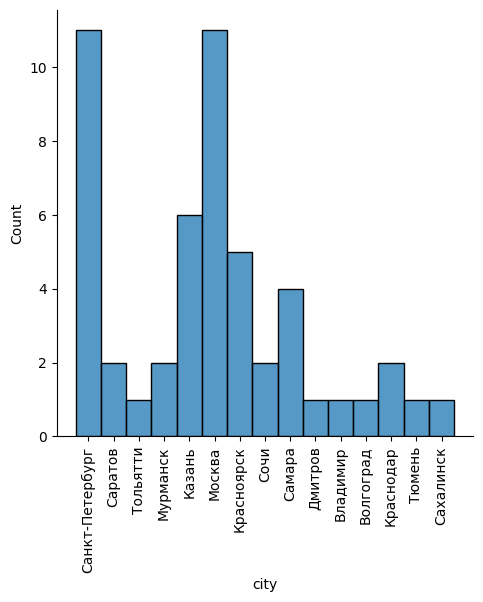

In [75]:
#Построим гистограмму распределения количества тестируемых торговых точек по городам за 3 месяца
sns.displot(df_ttest_tp, x = 'city')
plt.xticks(rotation=90)
plt.show()

In [76]:
df_ttest_tp.head()

,id_trading_point,ttest,pvalue_ttest,city
0,112.0,-0.742685,0.458019,Санкт-Петербург
1,80.0,0.345001,0.730210,Саратов
2,88.0,-0.521007,0.603216,Тольятти
3,55.0,1.770629,0.077772,Мурманск
4,477.0,-1.042116,0.298512,Казань


In [77]:
#Исследуем количество торговых точек в каждом городе
dt_ttest_tp_1 = pd.DataFrame(df_ttest_tp['id_trading_point'].unique().astype(int))
dt_ttest_tp_1.columns = ['id_trading_point']
dt_ttest_tp_1.head()

,id_trading_point
0,112
1,80
2,88
3,55
4,477


In [78]:
#Исследуем количество торговых точек в каждом городе за 3 месяца
df_tp_hist = df_tp.groupby('city').count().reset_index()
df_tp_hist.columns = ['city','quan_tp']
df_tp_hist

,city,quan_tp
0,Великий Новгород,1
1,Владимир,1
2,Волгоград,1
3,Дмитров,1
4,Казань,6
5,Краснодар,4
6,Красноярск,5
7,Москва,11
8,Мурманск,2
9,Нижний Новгород,1


In [79]:
#Исследуем количество тестируемых торговых точек в каждом городе
dt_ttest_tp_h = pd.merge(dt_ttest_tp_1, df_tp, on = 'id_trading_point')
dt_ttest_tp_hist = dt_ttest_tp_h.groupby('city').count().reset_index()
dt_ttest_tp_hist.columns = ['city','quan_tp']
dt_ttest_tp_hist


,city,quan_tp
0,Владимир,1
1,Волгоград,1
2,Дмитров,1
3,Казань,6
4,Краснодар,2
5,Красноярск,5
6,Москва,11
7,Мурманск,2
8,Самара,4
9,Санкт-Петербург,11


<function matplotlib.pyplot.show(close=None, block=None)>

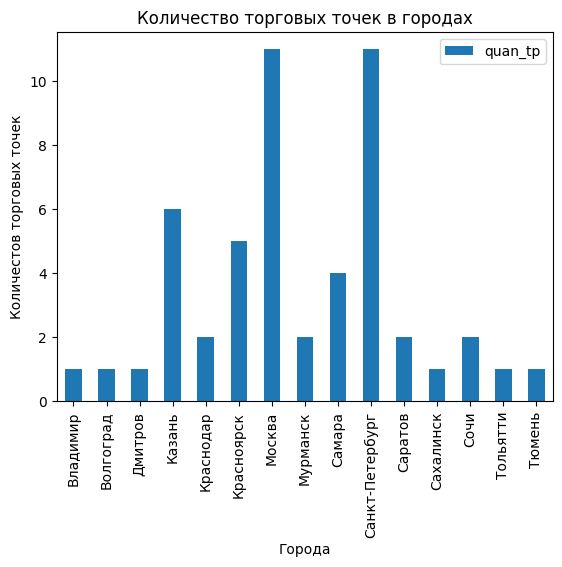

In [80]:
#Построим гистограмму распределения количества тестируемых торговых точек по городам за 3 месяца
dt_ttest_tp_hist.plot.bar(y ='quan_tp', x = 'city')
plt.title('Количество торговых точек в городах')
plt.xlabel('Города')
plt.ylabel('Количестов торговых точек')
plt.show

In [81]:
#Функция подсчета количества, средних и стандартного отклонения
agg_func = {'nflag_test':['count'], 'amt_payment' :['mean', 'std']}

In [82]:
#Рассчитаем количество наблюдений, средний платеж, стандартное отклонение в контрольной группе
dfg_0 = df_0.groupby(['id_trading_point']).agg(agg_func).reset_index()
dfg_0.head()

id_trading_point nflag_test  amt_payment             
                        count         mean          std
0                2          5  3896.600000  1399.426776
1               11        181  3594.029466  1393.520654
2               19         40  3280.050000  1242.559805
3               33        100  3382.780000  1364.350186
4               34         71  3560.239437  1537.383693

In [83]:
#Рассчитаем количество наблюдений, средний платеж, стандартное отклонение в тестовой группе
dfg_1 = df_1.groupby(['id_trading_point']).agg(agg_func).reset_index()
dfg_1.head()

id_trading_point nflag_test  amt_payment             
                        count         mean          std
0                2          8  3124.375000  1321.744971
1               11        174  3728.034483  1325.388037
2               19         38  3169.131579  1327.051256
3               33        146  3344.834475  1308.239237
4               34        104  3710.501603  1338.995718

In [84]:
#Соединим таблицы контрольной и тестовой группы
dfg_s = pd.merge(dfg_0, dfg_1, on = 'id_trading_point').droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()
dfg_s.head()

<ipython-input-84-8517e2ac043c>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfg_s = pd.merge(dfg_0, dfg_1, on = 'id_trading_point').droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()


,index,,count,mean,std,count,mean,std
0,0,2,5,3896.600000,1399.426776,8,3124.375000,1321.744971
1,1,11,181,3594.029466,1393.520654,174,3728.034483,1325.388037
2,2,19,40,3280.050000,1242.559805,38,3169.131579,1327.051256
3,3,33,100,3382.780000,1364.350186,146,3344.834475,1308.239237
4,4,34,71,3560.239437,1537.383693,104,3710.501603,1338.995718


In [85]:
dfg_s.columns = ['index','id_trading_point', 'count_control', 'avg_payment_control', 'sigma_control', 'count_test', 'avg_payment_test', 'sigma_test']
dfg_s.head()

,index,id_trading_point,count_control,avg_payment_control,sigma_control,count_test,avg_payment_test,sigma_test
0,0,2,5,3896.600000,1399.426776,8,3124.375000,1321.744971
1,1,11,181,3594.029466,1393.520654,174,3728.034483,1325.388037
2,2,19,40,3280.050000,1242.559805,38,3169.131579,1327.051256
3,3,33,100,3382.780000,1364.350186,146,3344.834475,1308.239237
4,4,34,71,3560.239437,1537.383693,104,3710.501603,1338.995718


In [86]:
dfg_sum = pd.merge(dfg_s, df_ttest_tp, how='left', on = 'id_trading_point')
dfg_sum.head()

,index,id_trading_point,count_control,avg_payment_control,sigma_control,count_test,avg_payment_test,sigma_test,ttest,pvalue_ttest,city
0,0,2,5,3896.600000,1399.426776,8,3124.375000,1321.744971,1.003008,0.337411,Дмитров
1,1,11,181,3594.029466,1393.520654,174,3728.034483,1325.388037,-0.927693,0.354201,Владимир
2,2,19,40,3280.050000,1242.559805,38,3169.131579,1327.051256,0.381225,0.704100,Тюмень
3,3,33,100,3382.780000,1364.350186,146,3344.834475,1308.239237,0.219582,0.826380,Самара
4,4,34,71,3560.239437,1537.383693,104,3710.501603,1338.995718,-0.686108,0.493564,Самара


In [87]:
dfg_sum['count_all'] = dfg_sum['count_test'] + dfg_sum['count_control']
dfg_sum['percent_count'] = dfg_sum['count_all'] / dfg_sum['count_all'].sum()
dfg_sum['diff'] = dfg_sum['avg_payment_test'] - dfg_sum['avg_payment_control']
dfg_sum.head()

,index,id_trading_point,count_control,avg_payment_control,sigma_control,count_test,avg_payment_test,sigma_test,ttest,pvalue_ttest,city,count_all,percent_count,diff
0,0,2,5,3896.600000,1399.426776,8,3124.375000,1321.744971,1.003008,0.337411,Дмитров,13,0.000868,-772.225000
1,1,11,181,3594.029466,1393.520654,174,3728.034483,1325.388037,-0.927693,0.354201,Владимир,355,0.023705,134.005017
2,2,19,40,3280.050000,1242.559805,38,3169.131579,1327.051256,0.381225,0.704100,Тюмень,78,0.005208,-110.918421
3,3,33,100,3382.780000,1364.350186,146,3344.834475,1308.239237,0.219582,0.826380,Самара,246,0.016426,-37.945525
4,4,34,71,3560.239437,1537.383693,104,3710.501603,1338.995718,-0.686108,0.493564,Самара,175,0.011685,150.262166


In [88]:
dfg_sum = dfg_sum.drop(columns=['index'])


In [89]:
dfg_sum['flag'] = 1
ttest_cond = [(dfg_sum['diff'] > 0) & (dfg_sum['pvalue_ttest'] < 0.05), (dfg_sum['pvalue_ttest'] > 0.05), (dfg_sum['diff'] < 0) & (dfg_sum['pvalue_ttest'] < 0.05)]
flag_k = [1, 0, -1]
dfg_sum['flag'] = np.select(ttest_cond, flag_k)
dfg_sum.head()

,id_trading_point,count_control,avg_payment_control,sigma_control,count_test,avg_payment_test,sigma_test,ttest,pvalue_ttest,city,count_all,percent_count,diff,flag
0,2,5,3896.600000,1399.426776,8,3124.375000,1321.744971,1.003008,0.337411,Дмитров,13,0.000868,-772.225000,0
1,11,181,3594.029466,1393.520654,174,3728.034483,1325.388037,-0.927693,0.354201,Владимир,355,0.023705,134.005017,0
2,19,40,3280.050000,1242.559805,38,3169.131579,1327.051256,0.381225,0.704100,Тюмень,78,0.005208,-110.918421,0
3,33,100,3382.780000,1364.350186,146,3344.834475,1308.239237,0.219582,0.826380,Самара,246,0.016426,-37.945525,0
4,34,71,3560.239437,1537.383693,104,3710.501603,1338.995718,-0.686108,0.493564,Самара,175,0.011685,150.262166,0


In [90]:
dfg_sum = dfg_sum[['city', 'id_trading_point', 'count_test', 'count_control', 'count_all', 'percent_count', 'avg_payment_test', 'avg_payment_control', 'diff', 'sigma_test', 'sigma_control', 'ttest', 'pvalue_ttest', 'flag']]
dfg_sum.head()

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,flag
0,Дмитров,2,8,5,13,0.000868,3124.375000,3896.600000,-772.225000,1321.744971,1399.426776,1.003008,0.337411,0
1,Владимир,11,174,181,355,0.023705,3728.034483,3594.029466,134.005017,1325.388037,1393.520654,-0.927693,0.354201,0
2,Тюмень,19,38,40,78,0.005208,3169.131579,3280.050000,-110.918421,1327.051256,1242.559805,0.381225,0.704100,0
3,Самара,33,146,100,246,0.016426,3344.834475,3382.780000,-37.945525,1308.239237,1364.350186,0.219582,0.826380,0
4,Самара,34,104,71,175,0.011685,3710.501603,3560.239437,150.262166,1338.995718,1537.383693,-0.686108,0.493564,0


In [91]:
#Сохраним  итоговые данные в файл
dfg_sum.to_excel('/content/gdrive/MyDrive/Colab Notebooks/DP/dfg_9_11.xlsx')

In [92]:
#Визуализация
df_viz = df_not_pay_city
df_viz.head()

,id_client,amt_payment,nflag_test,id_trading_point,city,pay_flag
0,178563,768.0,1,112,Санкт-Петербург,1
1,178570,4644.0,1,80,Саратов,1
2,178572,1828.0,0,88,Тольятти,1
3,178575,4313.5,1,55,Мурманск,1
4,178577,6027.0,1,477,Казань,1


In [93]:
df_viz_1 = df_viz.loc[df_viz['amt_payment'] > 0]
df_viz_1.head()

,id_client,amt_payment,nflag_test,id_trading_point,city,pay_flag
0,178563,768.0,1,112,Санкт-Петербург,1
1,178570,4644.0,1,80,Саратов,1
2,178572,1828.0,0,88,Тольятти,1
3,178575,4313.5,1,55,Мурманск,1
4,178577,6027.0,1,477,Казань,1


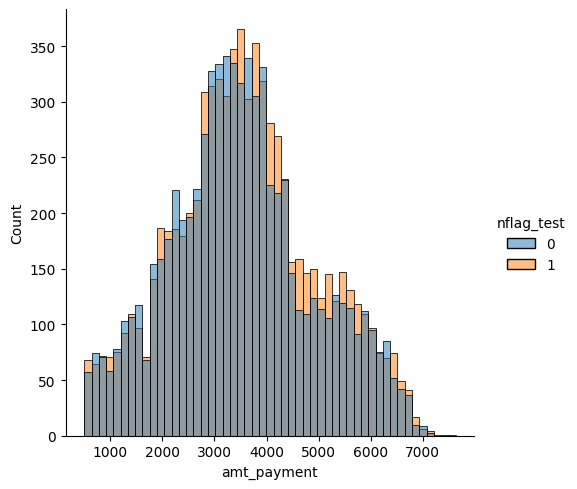

In [95]:
#Гистограмма распределения всех полатежей
sns.displot(df_viz, x = 'amt_payment', hue = 'nflag_test')
plt.show()

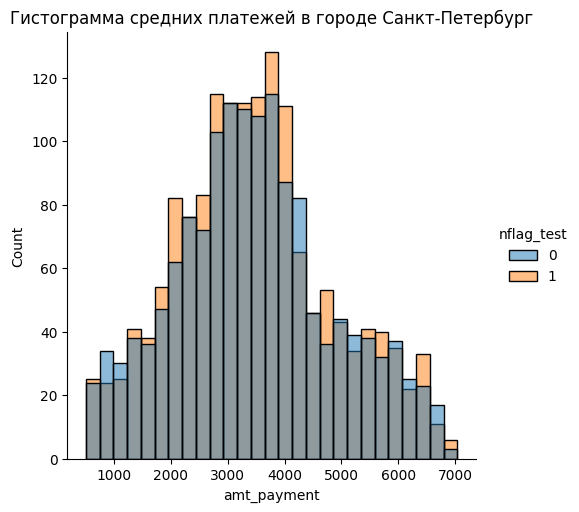

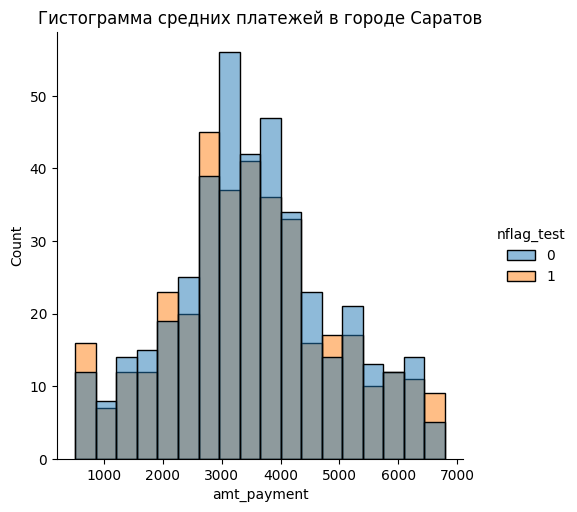

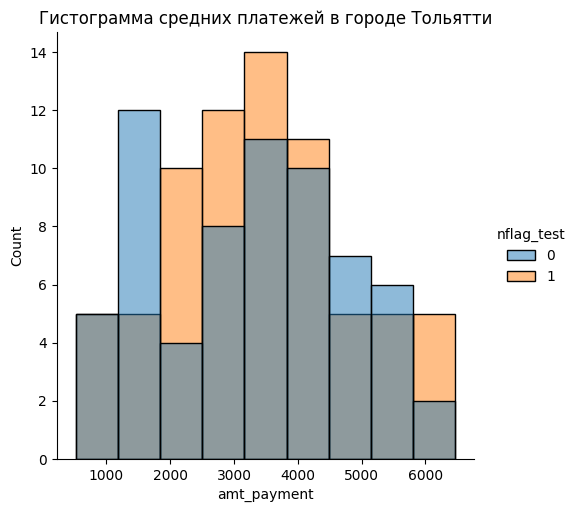

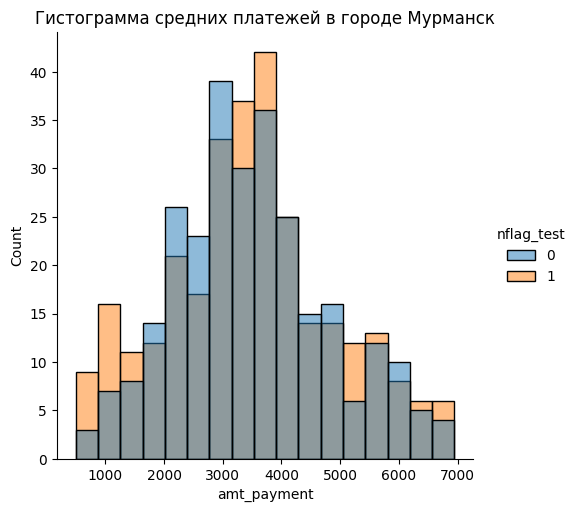

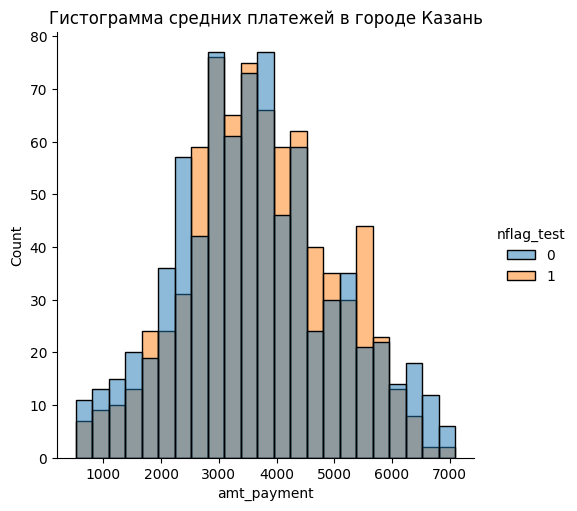

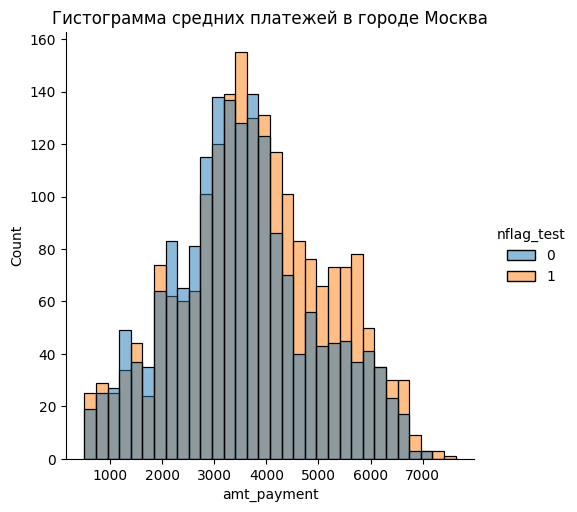

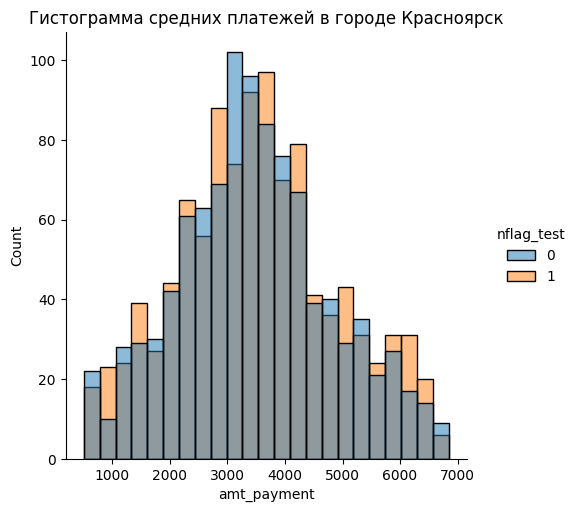

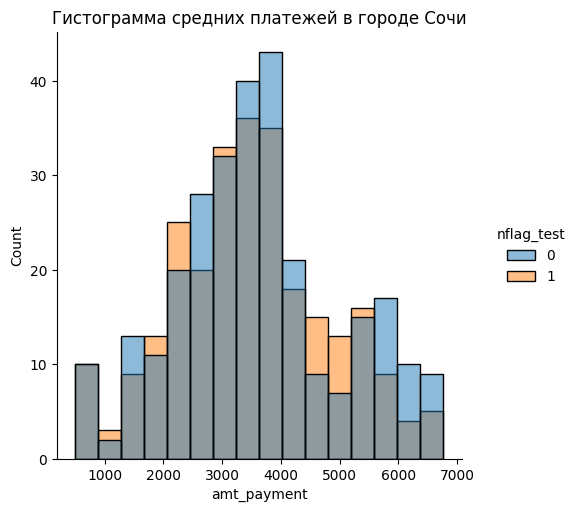

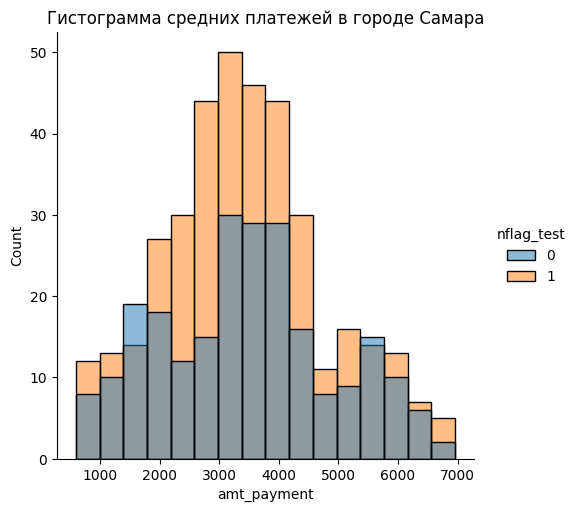

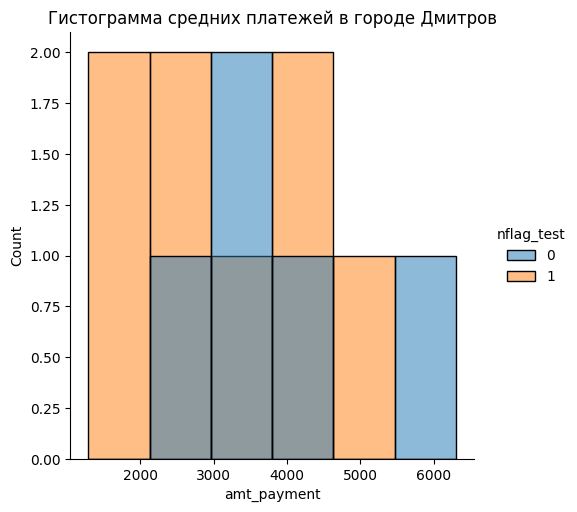

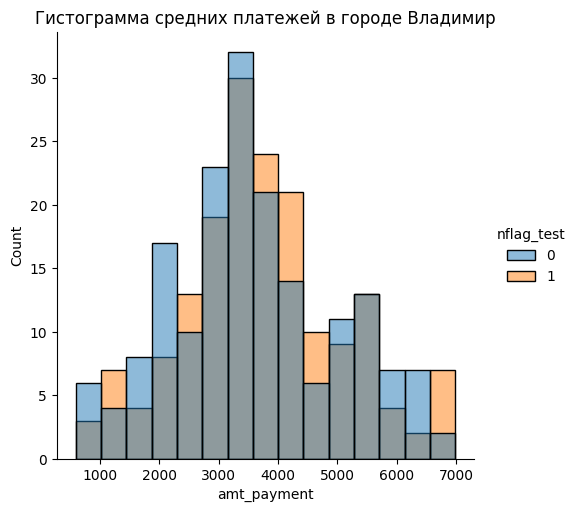

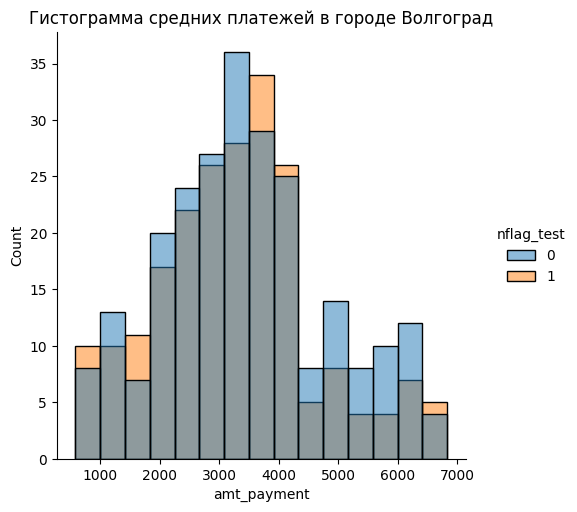

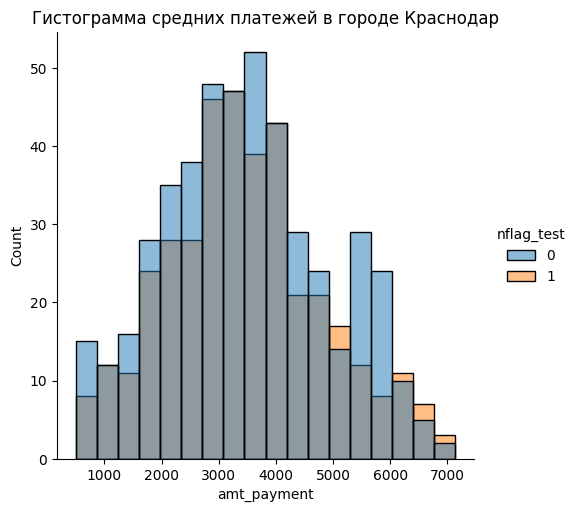

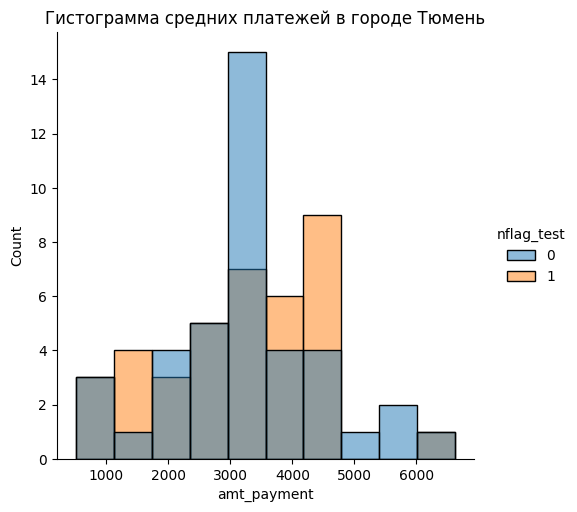

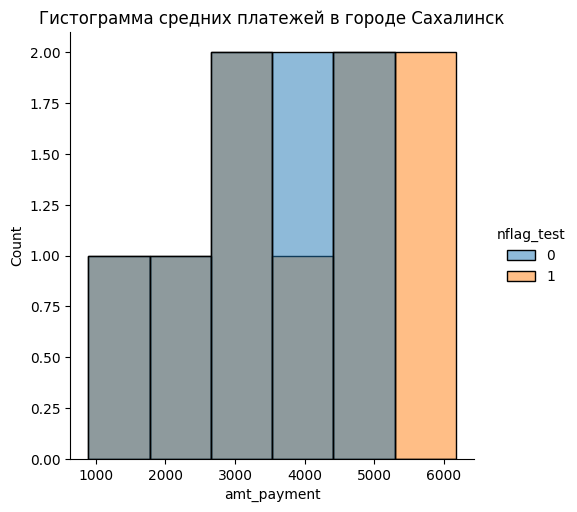

In [96]:
for i in df_viz['city'].unique():
  str_i = 'Гистограмма средних платежей в городе ' + i
  sns.displot(df_viz.loc[(df_viz['city'] == i) & (df_viz['amt_payment'] > 0)], x = 'amt_payment', hue = 'nflag_test')
  plt.title(str_i)
  plt.show()

In [ ]:
#Выгрузим полученные результаты в Excel. Разнесем результаты по трем разным листам в зависи мости от лейбла.
df_1 = dfg_sum.loc[dfg_sum['flag'] == 1]
df_0 = dfg_sum.loc[dfg_sum['flag'] == 0]
df__1 = dfg_sum.loc[dfg_sum['flag'] == -1]
with pd.ExcelWriter('/content/gdrive/MyDrive/Colab Notebooks/DP/dfg_sum_flag_9_11.xlsx', engine='xlsxwriter') as writer:
  df_1.to_excel(writer, sheet_name='1', index=False)
  df_0.to_excel(writer, sheet_name='0', index=False)
  df__1.to_excel(writer, sheet_name='-1', index=False)
